# Getting comparison star magnitudes directly from AAVSO

## This takes a bit of a roundabout path

In [10]:
from pathlib import Path
from collections import defaultdict

from IPython.display import Image

# Use this to read in a CCD image
from astropy.nddata import CCDData

# Use this to respresent the coordinates of the variable star
from astropy.coordinates import SkyCoord

# We will use table to read and write tables of data as CSV files (or as FITS)
from astropy.table import Table

# We will use this to get the APASS stars in the field of view of an image
from stellarphot.differential_photometry import find_apass_stars

import requests
import pandas as pd
import json

In [41]:
# Star chart parameters
var_star_name = 'V0533 Her'

# File for saving comparison star magnitudes in
apass_mags_comp_stars = 'apass-V0533-Her.csv'

# File for saving VSD comparison star magnitudes
vsd_mags_comp_stars = 'vsd-V0533-Her.csv'

# You chould not need to change these....
fov = 40
limiting_magnitude = 16

This is where the AAVSO server is called to get the chart for this star

In [12]:
payload = {'format':'json',
           'star': var_star_name,
           'fov': fov,
           'maglimit': limiting_magnitude
          }

r = requests.get('https://app.aavso.org/vsp/api/chart', params = payload)

print(r.url)

aavso_response = r.json()

https://app.aavso.org/vsp/api/chart/?format=json&star=V0533+Her&fov=40&maglimit=16


The response is not that easy to work with initially...

In [13]:
aavso_response


{'chartid': 'X34463AKJ',
 'image_uri': 'https://app.aavso.org/vsp/chart/X34463AKJ.png?format=json',
 'star': 'V0533 Her',
 'fov': 40.0,
 'maglimit': 16.0,
 'title': '',
 'comment': '',
 'resolution': 150,
 'dss': False,
 'special': None,
 'photometry': [{'auid': '000-BCS-520',
   'ra': '18:14:34.02',
   'dec': '41:51:18.5',
   'label': '119',
   'bands': [{'band': 'V', 'mag': 11.935, 'error': 0.096},
    {'band': 'B', 'mag': 12.437, 'error': 0.107},
    {'band': 'Ic', 'mag': 11.27, 'error': 0.156},
    {'band': 'J', 'mag': 10.887, 'error': 0.018},
    {'band': 'H', 'mag': 10.628, 'error': 0.017},
    {'band': 'K', 'mag': 10.576, 'error': 0.016}],
   'comments': ''},
  {'auid': '000-BCS-524',
   'ra': '18:14:37.93',
   'dec': '41:54:53.9',
   'label': '123',
   'bands': [{'band': 'V', 'mag': 12.256, 'error': 0.066},
    {'band': 'B', 'mag': 13.419, 'error': 0.093},
    {'band': 'Ic', 'mag': 10.865, 'error': 0.144},
    {'band': 'J', 'mag': 10.052, 'error': 0.019},
    {'band': 'H', 'mag

## We can display the finding chart pretty easily

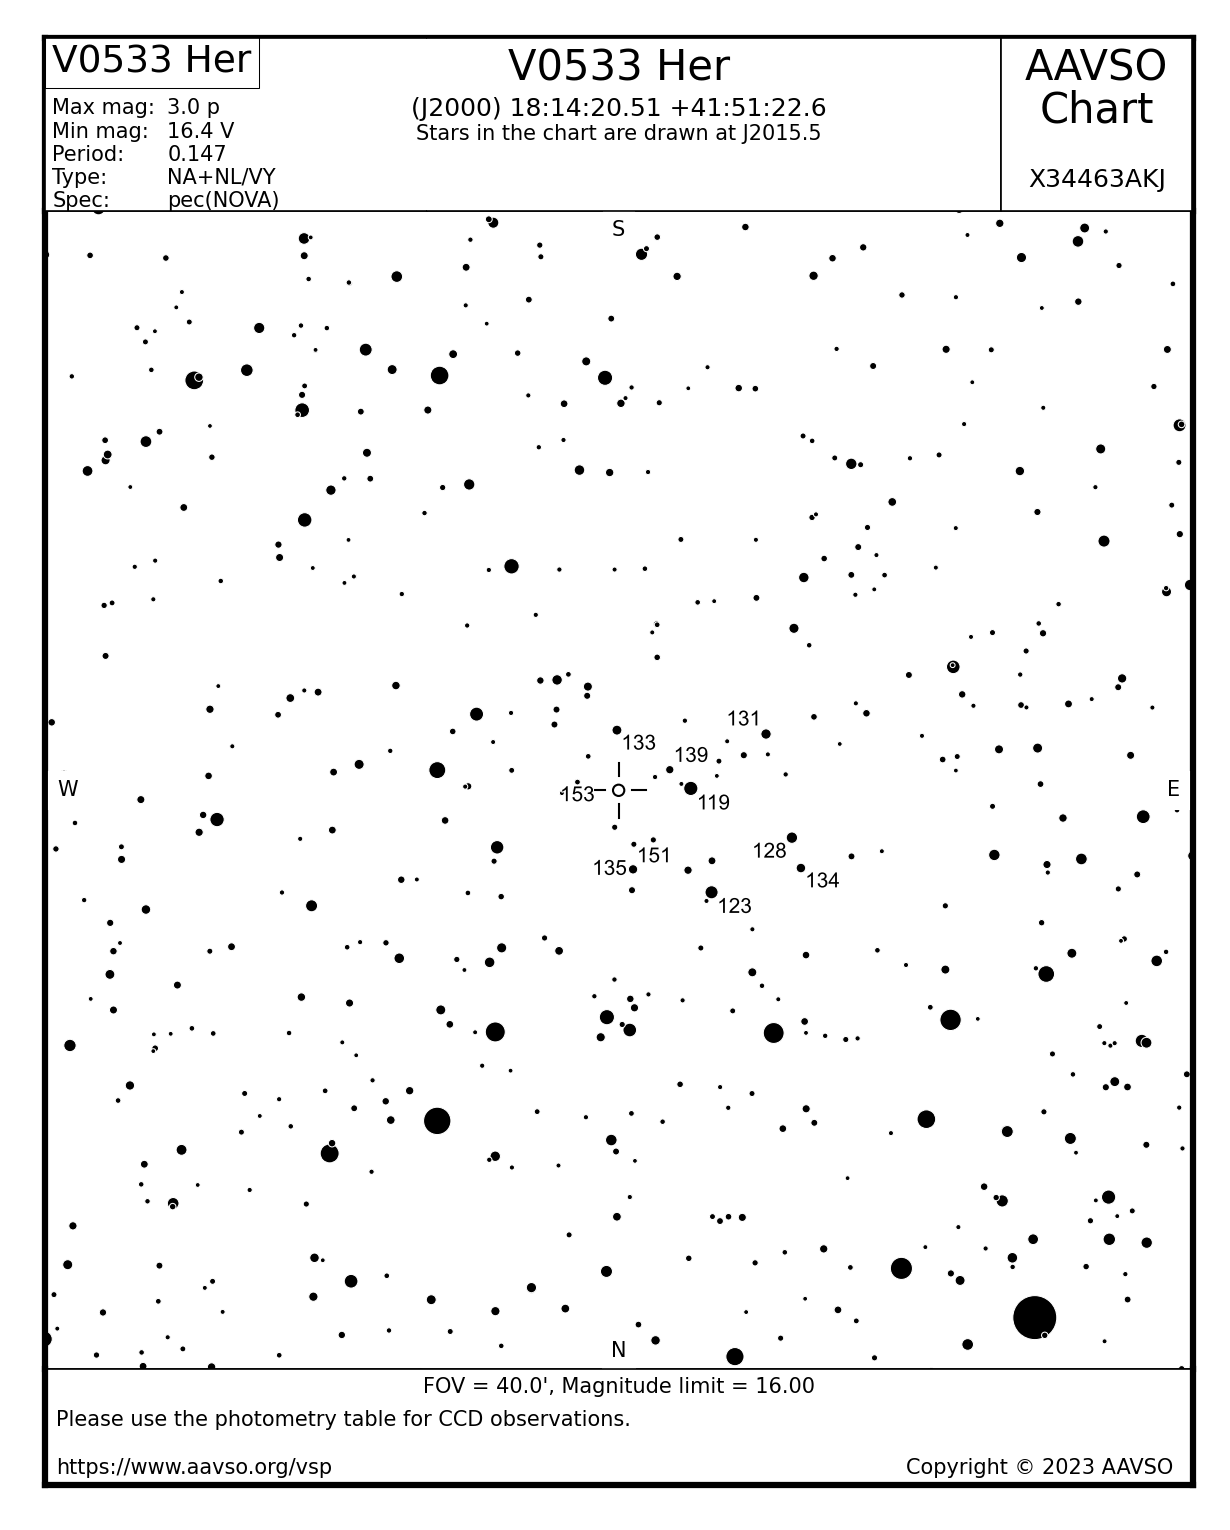

In [14]:
# Chop off the format argument at the end
image_uri = aavso_response['image_uri'].split("?")[0]
Image(image_uri)

In [15]:
var_coord = SkyCoord(ra=aavso_response['ra'], dec=aavso_response['dec'], unit=('hour', 'degree'))

In [16]:
if not aavso_response['photometry']:
    raise RuntimeError('No comparison stars for this variable -- request them from the AAVSO')


These shenanigans are to try to get the response into a more usable format

In [17]:
json = json.dumps(aavso_response['photometry'])
panda = pd.read_json(json, orient = 'records')

In [18]:
panda

,auid,ra,dec,label,bands,comments
0,000-BCS-520,18:14:34.02,41:51:18.5,119,"[{'band': 'V', 'mag': 11.935, 'error': 0.096},...",
1,000-BCS-524,18:14:37.93,41:54:53.9,123,"[{'band': 'V', 'mag': 12.256, 'error': 0.066},...",
2,000-BCS-531,18:14:52.94,41:53:00.3,128,"[{'band': 'V', 'mag': 12.756, 'error': 0.074},...",
3,000-BCS-529,18:14:48.07,41:49:26.0,131,"[{'band': 'V', 'mag': 13.09, 'error': 0.005}, ...",
4,000-BCS-512,18:14:20.20,41:49:18.3,133,"[{'band': 'V', 'mag': 13.273, 'error': 0.006},...",
5,000-BCS-532,18:14:54.61,41:54:03.3,134,"[{'band': 'V', 'mag': 13.437, 'error': 0.064},...",
6,000-BCS-514,18:14:23.19,41:54:06.0,135,"[{'band': 'V', 'mag': 13.491, 'error': 0.0}, {...",
7,000-BCS-517,18:14:30.10,41:50:39.5,139,"[{'band': 'V', 'mag': 13.939, 'error': 0.005},...",
8,000-BCS-515,18:14:23.35,41:53:14.3,151,"[{'band': 'V', 'mag': 15.078, 'error': 0.005},...",
9,000-BCS-510,18:14:12.81,41:51:05.1,153,"[{'band': 'V', 'mag': 15.32, 'error': 0.013000...",


In [19]:
aavso_comps = Table.from_pandas(panda)

In [20]:
aavso_comps['coords'] = SkyCoord(ra=aavso_comps['ra'], dec=aavso_comps['dec'], unit=('hour', 'degree'))

In [21]:
apass, apass_low_error = find_apass_stars(var_coord, max_mag_error=0.1, max_color_error=0.2)

apass['coords'] = SkyCoord(ra=apass['RAJ2000'], dec=apass['DEJ2000'], unit=('degree', 'degree'))



## Match the comp stars to APASS stars

One of the columns of the APASS table will be called `coords` and will be a list of coordinate objects. Astropy coordinates have the magical ability to match themselves to the coordinates of another set of coordinats.

You could use either the full apass list or the low error one below.

In [22]:
index, d2d, _ = aavso_comps['coords'].match_to_catalog_sky(apass['coords'])

In [23]:
if (d2d.arcsec > 1.5).any():
    raise RuntimeError('Coordinate mismatch')

In [24]:
apass_comp_stars = apass[index]

In [25]:
apass_comp_stars['auid'] = aavso_comps['auid']
apass_comp_stars['label'] = aavso_comps['label']

In [26]:
apass_mag_cols_band_map = dict(
    Vmag='V', Bmag='B', g_mag='SG', r_mag='SR', i_mag='SI'
)

mag_err_cols = {k: f'e_{k}' for k in apass_mag_cols_band_map.keys()}

In [27]:
del apass_comp_stars['coords'], apass_comp_stars['B-V'], apass_comp_stars['e_B-V']

In [28]:
constant_cols = set(apass_comp_stars.colnames) - set(apass_mag_cols_band_map.keys()) - set(mag_err_cols.values())

In [29]:
rearranged = defaultdict(list)
n_bands = len(apass_mag_cols_band_map.keys())

for row in apass_comp_stars:
    for cc in constant_cols:
        rearranged[cc].extend([row[cc]] * n_bands)
    for band, band_name in apass_mag_cols_band_map.items():
        rearranged['band'].append(band_name)
        rearranged['mag'].append(row[band])
        rearranged['mag_err'].append(row[mag_err_cols[band]])

In [30]:
rearranged = Table(rearranged)

In [35]:
rearranged[:10]

RAJ2000,recno,mobs,label,DEJ2000,nobs,Field,auid,e_DEJ2000,e_RAJ2000,band,mag,mag_err
float64,int32,int16,int64,float64,int16,int64,str11,float32,float32,str2,float32,float32
273.641704,14537579,36,119,41.855157,4,20121948,000-BCS-520,0.246,0.373,V,11.861,0.042
273.641704,14537579,36,119,41.855157,4,20121948,000-BCS-520,0.246,0.373,B,12.277,0.116
273.641704,14537579,36,119,41.855157,4,20121948,000-BCS-520,0.246,0.373,SG,12.039,0.053
273.641704,14537579,36,119,41.855157,4,20121948,000-BCS-520,0.246,0.373,SR,11.759,0.052
273.641704,14537579,36,119,41.855157,4,20121948,000-BCS-520,0.246,0.373,SI,11.677,0.055
273.657989,14537585,36,123,41.914956,4,20121948,000-BCS-524,0.493,0.469,V,12.174,0.066
273.657989,14537585,36,123,41.914956,4,20121948,000-BCS-524,0.493,0.469,B,13.28,0.114
273.657989,14537585,36,123,41.914956,4,20121948,000-BCS-524,0.493,0.469,SG,12.708,0.059
273.657989,14537585,36,123,41.914956,4,20121948,000-BCS-524,0.493,0.469,SR,11.81,0.045


In [32]:
rearranged.write(apass_mags_comp_stars, overwrite=True)

## Write AAVSO comparison magnitudes (from VSD)

Use similar logic to `rearranged` code above to get a flat table.



In [34]:
aavso_constant_cols = ['auid', 'ra', 'dec', 'label', 'comments']

In [38]:
rearranged = defaultdict(list)

for comp_star in aavso_response['photometry']:
    n_bands = len(comp_star['bands'])
    for cc in aavso_constant_cols:
        rearranged[cc].extend([comp_star[cc]] * n_bands)
    for band in comp_star['bands']:
        rearranged['band'].append(band['band'])
        rearranged['mag'].append(band['mag'])
        rearranged['mag_err'].append(band['error'])


In [40]:
vsd_rearranged = Table(rearranged)
vsd_rearranged[:5]

auid,ra,dec,label,comments,band,mag,mag_err
str11,str11,str10,str3,str1,str2,float64,float64
000-BCS-520,18:14:34.02,41:51:18.5,119,,V,11.935,0.096
000-BCS-520,18:14:34.02,41:51:18.5,119,,B,12.437,0.107
000-BCS-520,18:14:34.02,41:51:18.5,119,,Ic,11.27,0.156
000-BCS-520,18:14:34.02,41:51:18.5,119,,J,10.887,0.018
000-BCS-520,18:14:34.02,41:51:18.5,119,,H,10.628,0.017


In [42]:
vsd_rearranged.write(vsd_mags_comp_stars, overwrite=True)